# Defasagem Espacial Brasil  

### *Dados padronizados

Para fazer commit: `Ctrl + Shift + m`   
Reposotório: `spatial_cluster`   
Caminho do arquivo: `scripts/sul/defasagem_espacial_brasil.ipynb`

## Bibliotecas

In [1]:
!pip install geopandas==0.8.1
!pip install --upgrade pyshp
!pip install shapely==1.7.0
!pip install --upgrade descartes
!pip install mapclassify==2.3.0 libpysal==4.3.0 splot==1.1.3
!pip install esda

Requirement already up-to-date: pyshp in /home/walef/anaconda3/lib/python3.7/site-packages (2.1.0)
Requirement already up-to-date: descartes in /home/walef/anaconda3/lib/python3.7/site-packages (1.1.0)


In [2]:
import pandas as pd
import numpy as np
import scipy.stats as stats

# para gráficos
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
# sns.set(style='whitegrid', palette='pastel') 

# para a análise de componentes principais
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

# para a análise de dados espaciais
import geopandas
import splot
import mapclassify as mc
from libpysal.weights import Queen
from pysal.lib import weights
from esda import Moran, Moran_Local, G_Local
from splot.esda import plot_moran, moran_scatterplot, lisa_cluster, plot_local_autocorrelation

# para agrupamento - K-médias
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import cut_tree
from sklearn.cluster import KMeans

# para avaliar grupos 
from sklearn import metrics
from sklearn.metrics import pairwise_distances
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics.cluster import contingency_matrix


## Dados

https://www.gov.br/agricultura/pt-br/assuntos/riscos-seguro/seguro-rural/relatorios-estatisticos

In [3]:
link = 'https://raw.githubusercontent.com/walefmachado/spatial_cluster/master/data/'

In [4]:
# função para deixar todos os nomes de municípios iguais (sem acento, sem espaço)
def simplificar_nomes(df, variavel):
  df[variavel] = (df[variavel].str.strip()
                 .str.lower()
                 .str.replace(' ', '_')
                 .str.replace('\'', '')
                 .str.replace('-','_')
                 .str.replace('á', 'a')
                 .str.replace('é', 'e')
                 .str.replace('í', 'i')
                 .str.replace('ó', 'o')
                 .str.replace('ú', 'u')
                 .str.replace('â', 'a')
                 .str.replace('ê', 'e')
                 .str.replace('ô', 'o')
                 .str.replace('í', 'i')
                 .str.replace('ã','a')
                 .str.replace('õ','o')
                 .str.replace('ç','c')
                 .str.replace('à', 'a')
                 .str.replace('ü', 'u'))

### Dados de seguro rural

In [5]:
dados18 = pd.read_csv(link+'/seguro18.csv', encoding='utf-8')
dados18.head()

,ano,uf,nome_mun,cultura,seguradora,evento_sinistro,apolices_contratadas,total_segurado_mil,soma_premio_total_mil,total_subvencao_mil,valor_indenizacoes_pagas_mil,sinistralidade_media,taxa_media,apolices_indenizadas
0,2018,AC,Rio Branco,Pecuário,Mapfre,-,2,988246.80,9892.13,4451.45,0.00,0.0,0.01,0
1,2018,AL,Igaci,Milho 1ª safra,Aliança do Brasil,SECA,1,646644.90,51309.86,23089.44,514018.03,10018.0,79.00,1
2,2018,AL,Limoeiro de Anadia,Milho 1ª safra,Sancor,-,1,322882.69,29059.47,13076.76,0.00,0.0,0.09,0
3,2018,AL,Messias,Pecuário,Mapfre,-,1,386600.00,3869.78,1741.40,0.00,0.0,0.01,0
4,2018,AL,Santana do Mundaú,Pecuário,Mapfre,-,1,165920.00,1660.82,747.36,0.00,0.0,0.01,0


In [6]:
dados = dados18
cod = pd.read_csv(link+'/codigos-mun.csv')
cod = cod[['mun', 'nome_mun', 'nome_meso']]
cod.shape

(5570, 3)

In [7]:
# simplificar os nomes dos municípios nos dois dataframes
simplificar_nomes(cod, 'nome_mun')
simplificar_nomes(dados, 'nome_mun')

In [8]:
dados = dados.merge(cod, on='nome_mun', how='left')
dados.shape

(15395, 16)

In [9]:
dados = dados.drop('ano', axis=1).groupby('mun').sum()

In [10]:
dados.reset_index(level = 0, inplace = True)

In [11]:
dados.shape

(2293, 9)

In [12]:
dados = dados.merge(cod, on='mun')

In [13]:
dados.head()

,mun,apolices_contratadas,total_segurado_mil,soma_premio_total_mil,total_subvencao_mil,valor_indenizacoes_pagas_mil,sinistralidade_media,taxa_media,apolices_indenizadas,nome_mun,nome_meso
0,1100023.0,1,2300000.00,18456.81,8305.56,0.00,0.0,8.00,0,ariquemes,Leste Rondoniense
1,1100056.0,2,195143.31,10732.87,4829.80,0.00,0.0,55.00,0,cerejeiras,Leste Rondoniense
2,1100072.0,2,2548975.13,222758.25,89103.30,0.00,0.0,87.00,0,corumbiara,Leste Rondoniense
3,1100130.0,1,153645.48,9218.72,4148.42,0.00,0.0,0.06,0,machadinho_doeste,Leste Rondoniense
4,1100403.0,2,154950.18,9028.44,4062.80,39291.79,4352.0,58.00,2,alto_paraiso,Leste Rondoniense


In [14]:
# retirar = ['sinistralidade_media', 'taxa_media']
# dados = dados.drop(retirar, axis=1)
# dados.head()

In [15]:
seguro = dados # não sei porque fiz isso.. rs 

### Dados para espacial 

In [16]:
# seguro = pd.read_csv(link_p+'seguroagricola2017.csv', encoding='latin1') # troquei para 2018
cod = pd.read_csv(link+'cod-nome-corrigido.csv', encoding='latin1')

br = geopandas.read_file(link+'br.json')
br = br.rename(columns={'CD_GEOCMU': 'mun'})
br.mun = br.mun.astype(int)
br2 = br.drop('NM_MUNICIP', axis=1)

In [17]:
cod_dados = cod.merge(br2, how='left')
cod_dados = geopandas.GeoDataFrame(cod_dados) # Ate aqui junta geometry com todos os códigos 

In [18]:
# apolices = seguro.groupby('nome_mun').apolices_contratadas.sum()
# apolices = pd.DataFrame(apolices).reset_index()

In [19]:
dados_br = cod_dados.merge(seguro, how='left')

In [20]:
dados_br = dados_br.fillna(0)
dados_br = dados_br.drop([1525, 3499]) # retira F. Noronha e Ilhabela
dados_br = dados_br.drop(['Unnamed: 0', 'rm'], axis = 1)

In [21]:
# dados_br.to_csv(r'/home/walef/Dropbox/Mestrado/Dados/dados_multi_spati_teste.csv',index=False, header= True)

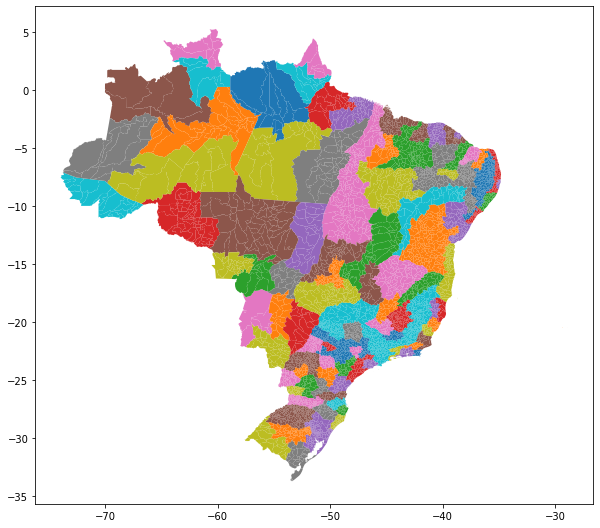

In [22]:
# dados_br.plot(column='apolices', figsize=(10, 10), scheme='quantiles', cmap='OrRd', legend=True, k=4);
dados_br.plot(column='nome_meso', figsize=(10, 10)); # , cmap='OrRd',  cmap='plasma'

## Pesos espaciais - Brasil

In [23]:
w = Queen.from_dataframe(dados_br)
w.transform = 'r'

In [24]:
dados_br.columns

Index(['uf', 'nome_uf', 'mun', 'nome_mun', 'meso', 'nome_meso', 'micro',
       'nome_micro', 'codmun6', 'regiao', 'nome_regiao', 'geometry',
       'apolices_contratadas', 'total_segurado_mil', 'soma_premio_total_mil',
       'total_subvencao_mil', 'valor_indenizacoes_pagas_mil',
       'sinistralidade_media', 'taxa_media', 'apolices_indenizadas'],
      dtype='object')

In [25]:
retirar = ['uf', 'nome_uf', 'mun', 'meso', 'nome_meso', 
           'micro', 'nome_micro', 'codmun6', 'regiao', 
           'nome_regiao'] # , 'geometry'
dados_lag = dados_br.drop(retirar, axis = 1)

In [26]:
dados_lag.columns

Index(['nome_mun', 'geometry', 'apolices_contratadas', 'total_segurado_mil',
       'soma_premio_total_mil', 'total_subvencao_mil',
       'valor_indenizacoes_pagas_mil', 'sinistralidade_media', 'taxa_media',
       'apolices_indenizadas'],
      dtype='object')

In [27]:
for variavel in dados_lag.drop(['nome_mun', 'geometry'], axis = 1).columns:
    dados_lag[variavel+'_lag'] = weights.spatial_lag.lag_spatial(w, dados_lag[variavel])

In [28]:
dados_lag = dados_lag.set_index('nome_mun')

In [29]:
dados_lag.head()

,geometry,apolices_contratadas,total_segurado_mil,soma_premio_total_mil,total_subvencao_mil,valor_indenizacoes_pagas_mil,sinistralidade_media,taxa_media,apolices_indenizadas,apolices_contratadas_lag,total_segurado_mil_lag,soma_premio_total_mil_lag,total_subvencao_mil_lag,valor_indenizacoes_pagas_mil_lag,sinistralidade_media_lag,taxa_media_lag,apolices_indenizadas_lag
nome_mun,,,,,,,,,,,,,,,,,
alta_floresta_doeste,"POLYGON ((-62.19465 -11.82746, -62.17332 -11.8...",0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ariquemes,"POLYGON ((-62.53648 -9.73222, -62.49559 -9.772...",1.0,2300000.00,18456.81,8305.56,0.0,0.0,8.0,0.0,1.571429,6.208754e+05,38979.591429,15848.868571,5613.112857,621.714286,26.161429,0.285714
cabixi,"POLYGON ((-60.37075 -13.36363, -60.37959 -13.3...",0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,6.000000,4.149398e+06,163459.245000,63393.330000,0.000000,0.000000,107.035000,0.000000
cacoal,"POLYGON ((-61.00080 -11.29737, -61.00302 -11.4...",0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
cerejeiras,"POLYGON ((-61.49976 -13.00525, -61.43437 -13.0...",2.0,195143.31,10732.87,4829.80,0.0,0.0,55.0,0.0,1.333333,9.841703e+05,83784.586667,33990.426667,0.000000,0.000000,72.666667,0.000000


## Análise de agrupamento - Defasagem espacial

In [30]:
# subselecionar variáveis
X = scale(dados_lag.drop('geometry', axis=1))

In [31]:
# mudar o tipo dos dados
X = np.asarray(X, dtype=float)
n = X.shape[0]
p = X.shape[1]
# vetor de médias
Xb = np.mean(X, axis=0)
# matriz de covariâncias
S = np.cov(X.T)
# matriz de somas de quadrados e produtos
W = (n - 1) * S

In [32]:
Z = linkage(X, method='ward')

In [33]:
max_d = 0
grupos = cut_tree(Z, height=max_d)

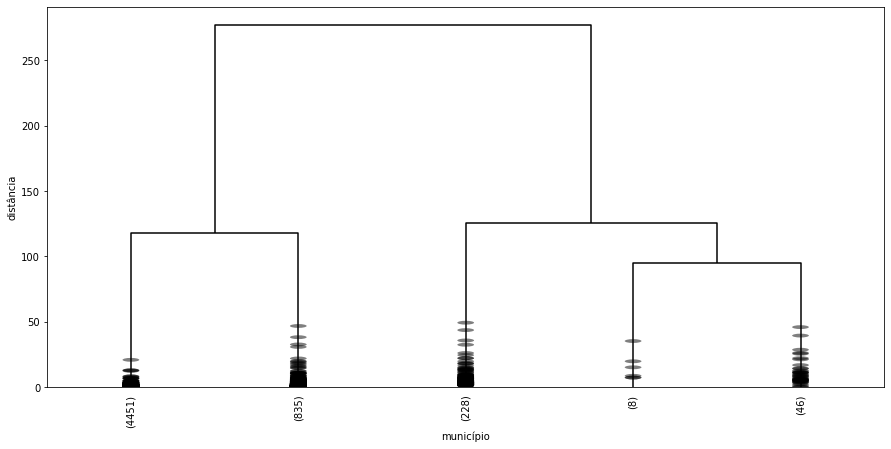

In [34]:
fig, ax = plt.subplots(figsize=(15, 7))
ax = dendrogram(
    Z,
    truncate_mode='lastp',  # mostrar apenas os p últimos grupos formados
    p=5,  # quantos passos mostrar
    show_leaf_counts=True,  # mostrar quantas observações há em cada grupo entre parênteses
    leaf_rotation=90., # rotação
    leaf_font_size=10., # tamanho da fonte
    labels=dados.index, # rótulos do eixo x
    show_contracted=True,  # to get a distribution impression in truncated branches,
    above_threshold_color='black',
    color_threshold=0.1, # para que todas as linhas sejam da mesma cor
    # color_threshold=max_d, # para que os grupos fiquem com cores diferentes
)
plt.axhline(y=max_d, c='grey', lw=1, linestyle='dashed')
plt.xlabel('município')
plt.ylabel('distância');

**Método escolhido:** 

In [35]:
Z = linkage(X, method='ward')

In [36]:
# definir a distância de corte baseando no dendrograma
max_d = 80
grupos = cut_tree(Z, height=max_d)

### Métricas

In [37]:
dados_metrics = dados_lag.drop('geometry', axis=1)

In [38]:
# métricas
print(
  round(metrics.calinski_harabasz_score(X, grupos.ravel()),2),
  round(davies_bouldin_score(X, grupos.ravel()),2),
  round(metrics.silhouette_score(X, grupos.ravel(), metric='euclidean'),2)  
)

2565.08 1.2 0.67


In [39]:
  # incluir no dataframe de dados as informações sobre a qual grupo cada observação pertence
dados_lag['grupo'] = grupos
# moran_matrix.head(2)

In [40]:
# contagem de observações em cada grupo
dados_lag.grupo.value_counts()

0    4451
1     835
3     228
2      46
4       8
Name: grupo, dtype: int64

In [41]:
# média dos grupos - todas as variáveis
# inclusive as não utilizadas para agrupar
dados_lag.groupby('grupo').mean()

,apolices_contratadas,total_segurado_mil,soma_premio_total_mil,total_subvencao_mil,valor_indenizacoes_pagas_mil,sinistralidade_media,taxa_media,apolices_indenizadas,apolices_contratadas_lag,total_segurado_mil_lag,soma_premio_total_mil_lag,total_subvencao_mil_lag,valor_indenizacoes_pagas_mil_lag,sinistralidade_media_lag,taxa_media_lag,apolices_indenizadas_lag
grupo,,,,,,,,,,,,,,,,
0,1.795776,4.020873e+05,2.105040e+04,9.010495e+03,1.484046e+04,523.730863,40.324183,0.235228,3.018340,6.867533e+05,3.764583e+04,1.611819e+04,3.050227e+04,832.177214,58.096819,0.525633
1,27.346108,6.369383e+06,3.822235e+05,1.621890e+05,3.812868e+05,7743.456287,477.649293,6.073054,35.885266,8.369882e+06,5.500753e+05,2.331395e+05,5.006519e+05,8981.386659,552.988667,7.965391
2,301.108696,6.514352e+07,5.449130e+06,2.320032e+06,5.607932e+06,47706.657826,2400.105435,95.108696,97.788589,2.236048e+07,1.849368e+06,7.942500e+05,1.726551e+06,21380.021265,1186.737678,29.774921
3,100.934211,1.624712e+07,1.257369e+06,5.453255e+05,1.219097e+06,25335.045395,1507.037675,30.192982,135.591704,2.308678e+07,1.783334e+06,7.706533e+05,2.052071e+06,28921.424758,1604.991790,44.433957
4,492.125000,4.598523e+07,3.187202e+06,1.434240e+06,1.487948e+07,49783.237500,1475.403750,316.250000,413.083333,3.855622e+07,2.779164e+06,1.250298e+06,1.050517e+07,34973.321042,1558.288594,225.781250


In [42]:
# mediana das variáveis para cada grupo
dados_lag.groupby('grupo').median()

,apolices_contratadas,total_segurado_mil,soma_premio_total_mil,total_subvencao_mil,valor_indenizacoes_pagas_mil,sinistralidade_media,taxa_media,apolices_indenizadas,apolices_contratadas_lag,total_segurado_mil_lag,soma_premio_total_mil_lag,total_subvencao_mil_lag,valor_indenizacoes_pagas_mil_lag,sinistralidade_media_lag,taxa_media_lag,apolices_indenizadas_lag
grupo,,,,,,,,,,,,,,,,
0,0.0,0.000000e+00,0.00,0.000,0.000000e+00,0.000,0.000,0.0,0.333333,8.358571e+04,3.276608e+03,1.418104e+03,0.000000e+00,0.000000,9.500000,0.000000
1,16.0,3.235683e+06,212263.45,92296.860,3.392500e+04,1926.000,297.000,1.0,29.666667,7.077647e+06,4.702974e+05,2.011899e+05,3.068008e+05,6872.666667,466.062500,5.272727
2,289.5,5.348178e+07,4281213.56,1882600.080,5.118482e+06,47141.370,2273.465,81.0,110.850000,1.822179e+07,1.393500e+06,6.136940e+05,1.468905e+06,21571.941250,1132.858571,24.437500
3,87.0,1.280637e+07,1030654.48,455377.895,8.584573e+05,24770.455,1577.425,22.0,128.750000,2.063357e+07,1.599230e+06,7.029761e+05,1.702385e+06,30564.543333,1736.863750,39.270833
4,441.0,4.611380e+07,3028325.68,1362745.360,1.295144e+07,38748.630,1545.810,259.5,420.500000,3.863781e+07,2.558148e+06,1.151166e+06,9.461256e+06,35207.352917,1574.305000,195.208333


### As observações de cada grupo


In [43]:
#grupo0 = dados.query('grupo == 0').index
#list(grupo0)

### Mapa Grupos com defasagem espacial

In [44]:
dados_lag['grupo'] = dados_lag['grupo'].astype('category')

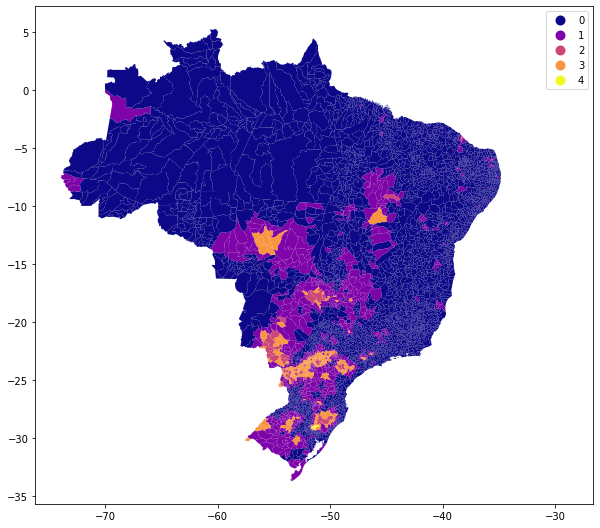

In [45]:
dados_lag.plot(column='grupo', figsize=(10, 10), legend=True, cmap = 'plasma'); # , cmap='OrRd'

## K-Médias - Defasagem espacial


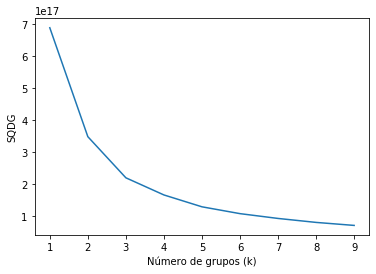

In [46]:
# SQDG
SQDG = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(dados_lag.drop('geometry', axis=1))
    dados_lag['grupos'] = kmeans.labels_
    SQDG[k] = kmeans.inertia_ # Inertia: soma das distâncias das obs. ao centro mais próximo
plt.figure()
plt.plot(list(SQDG.keys()), list(SQDG.values()))
plt.xlabel('Número de grupos (k)')
plt.ylabel('SQDG');

In [47]:
k = 5

In [48]:
kmeans = KMeans(n_clusters=k, random_state=10).fit(X)

### Métricas

In [49]:
# métricas
print(
  round(metrics.calinski_harabasz_score(X, kmeans.labels_),2),
  round(davies_bouldin_score(X, kmeans.labels_),2),
  round(metrics.silhouette_score(X, kmeans.labels_, metric='euclidean'),2)  
)

2813.91 1.16 0.73


In [50]:
# incluir no resultado dos escores dos dois primeiros CPs a informação sobre os grupos obtidos 
# com o método das k-médias
dados_lag['grupo'] = kmeans.labels_

In [51]:
# contagens
dados_lag.grupo.value_counts()

0    4741
3     587
2     184
1      49
4       7
Name: grupo, dtype: int64

In [52]:
# incluir no dataframe de dados as informações sobre a qual grupo cada município pertence
# dados['grupo'] = kmeans.labels_

In [53]:
# média dos grupos - todas as variáveis
# inclusive as não utilizadas para agrupar
dados_lag.groupby('grupo').mean()

,apolices_contratadas,total_segurado_mil,soma_premio_total_mil,total_subvencao_mil,valor_indenizacoes_pagas_mil,sinistralidade_media,taxa_media,apolices_indenizadas,apolices_contratadas_lag,total_segurado_mil_lag,soma_premio_total_mil_lag,total_subvencao_mil_lag,valor_indenizacoes_pagas_mil_lag,sinistralidade_media_lag,taxa_media_lag,apolices_indenizadas_lag,grupos
grupo,,,,,,,,,,,,,,,,,
0,2.311960,5.586937e+05,2.875233e+04,1.217625e+04,1.787565e+04,613.698724,48.588188,0.298671,4.026454,9.682423e+05,5.493763e+04,2.347873e+04,4.295258e+04,1056.943501,73.793418,0.703365,0.770513
1,294.367347,6.627556e+07,5.421648e+06,2.302377e+06,5.205117e+06,44563.254694,2256.253265,90.673469,103.527553,2.312979e+07,1.902909e+06,8.176286e+05,1.679099e+06,20155.332621,1150.366859,30.938337,3.367347
2,108.478261,1.456852e+07,1.148540e+06,5.048728e+05,1.469726e+06,29977.603913,1691.350217,36.608696,151.137286,2.309135e+07,1.821732e+06,7.937451e+05,2.305958e+06,33570.703573,1822.932999,52.217169,4.054348
3,38.829642,8.987302e+06,5.780200e+05,2.457142e+05,5.350787e+05,10510.496474,648.279540,8.466780,46.430122,1.090942e+07,7.356604e+05,3.104207e+05,6.729792e+05,11270.279936,681.354902,10.508850,6.057922
4,498.571429,4.636119e+07,3.297852e+06,1.484033e+06,1.643773e+07,55341.271429,1638.747143,334.571429,412.952381,3.856709e+07,2.863655e+06,1.288272e+06,1.141366e+07,38512.401905,1675.896964,238.607143,4.428571


In [54]:
# mediana das variáveis para cada grupo
dados_lag.groupby('grupo').median()

,apolices_contratadas,total_segurado_mil,soma_premio_total_mil,total_subvencao_mil,valor_indenizacoes_pagas_mil,sinistralidade_media,taxa_media,apolices_indenizadas,apolices_contratadas_lag,total_segurado_mil_lag,soma_premio_total_mil_lag,total_subvencao_mil_lag,valor_indenizacoes_pagas_mil_lag,sinistralidade_media_lag,taxa_media_lag,apolices_indenizadas_lag,grupos
grupo,,,,,,,,,,,,,,,,,
0,0.0,0.00,0.000,0.000,0.00,0.000,0.000,0.0,0.500000,1.158835e+05,4.756038e+03,2.110725e+03,0.000000e+00,0.000000,13.000000,0.00,0
1,269.0,53601520.21,4282426.370,1876541.660,4787901.38,46396.000,1927.530,71.0,118.200000,1.839383e+07,1.430643e+06,6.143044e+05,1.384242e+06,20220.224286,1083.601250,24.25,3
2,95.0,12302800.29,1008214.305,442757.315,1090168.53,30873.025,1701.735,29.5,145.464286,2.054522e+07,1.630654e+06,7.169792e+05,1.899622e+06,34280.416250,1896.531875,45.60,4
3,26.0,5765609.24,403744.560,175888.860,167571.00,6179.000,500.000,4.0,40.666667,9.368523e+06,6.266360e+05,2.642780e+05,4.512603e+05,9678.857500,599.257500,7.25,7
4,435.0,48874115.54,3644003.600,1639800.430,16131750.39,40118.000,1637.380,269.0,427.000000,3.879543e+07,2.674738e+06,1.203631e+06,9.881675e+06,45906.093333,1827.090000,199.75,4


In [55]:
#grupo0 = mg.query('grupo == 0').index
#list(grupo0)

### Mapa Grupos com defasagem espacial

In [56]:
dados_lag['grupo'] = dados_lag['grupo'].astype('category')

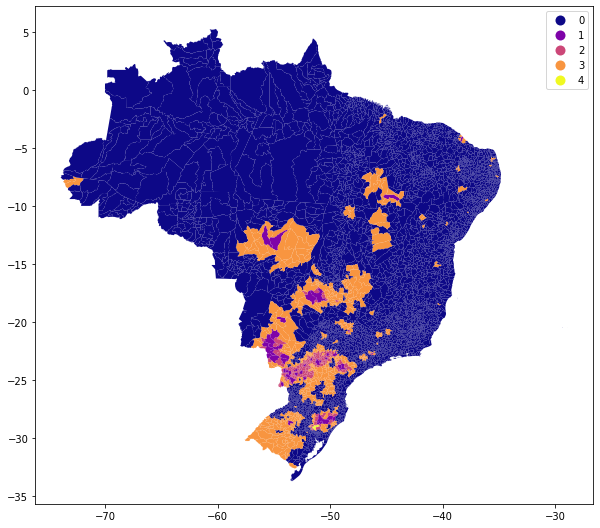

In [57]:
dados_lag.plot(column='grupo', figsize=(10, 10), legend=True, cmap = 'plasma'); # , cmap='OrRd'